# This notebook aims to the determination of best values for aperture and zero based on lowering the chi2 value.
* Fernando Falkenberg, INPE 17 Aug 2025

In [1]:
from astropy.io import fits, ascii
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sparc4.product_plots as s4plt
import sparc4.pipeline_lib as s4pipelib
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Set paths to example files

In [2]:
pasta='/media/fernando/KINGSTON/Doutorado/2025/reduced'
night='20250325'
channel='1'
object='V1025Cen'

polar_stack_example = f'{pasta}/{night}/sparc4acs{channel}/{night}_s4c{channel}_Gain2_1.0_Conventional_2_{object}_POLAR_L4_stack.fits'
polar_example =       f'{pasta}/{night}/sparc4acs{channel}/{night}_s4c{channel}_Gain2_1.0_Conventional_2_{object}_POLAR_L4_polar.fits'

First we plot the science frame using the `sparc4.product_plots` library

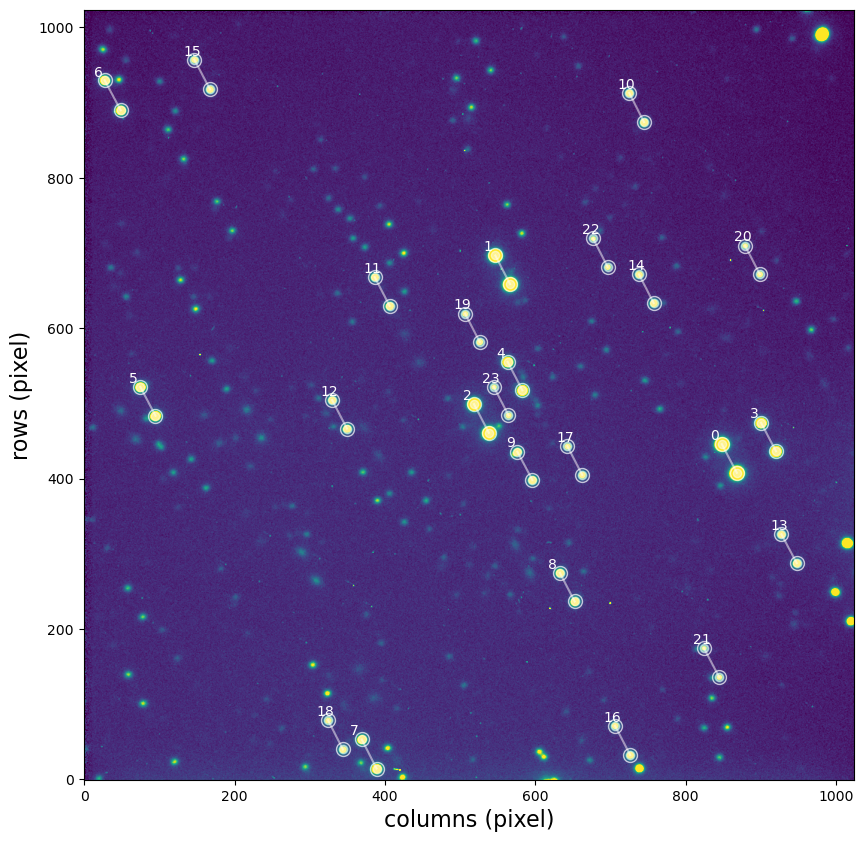

In [3]:
s4plt.plot_sci_polar_frame(polar_stack_example)

Next, based on the image above, we have to determine the source_index.

In [4]:
#First, we select the source of interest. 
source_index = 2

#Then, we select the values of zero and aperture we want to search for the best values
range_zero = np.arange(0,91)
range_aper = np.arange(5,22)

#And then we get the polarimetry results for every combination of zero and aperture using the function `get_polarimetry_results` from `sparc4.pipeline_lib` library:
produto3D=[]

for j in range_aper:
    produto=[]
    for i in range_zero:
        pol_results = []
        pol_results = s4pipelib.get_polarimetry_results(polar_example,
                                                source_index=source_index,
                                                min_aperture=j,
                                                max_aperture=j,
                                                plot=False,
                                                verbose=False,
                                                zero=i,
                                                compute_k=True)
        produto.append(pol_results)
    produto3D.append(produto)

/home/fernando/anaconda3/lib/python3.12/site-packages/astropop/math/_deriv.py:29: RuntimeWarning: invalid value encountered in log
  return np.log(x)*np.power(x, y)


In [5]:
# Criando listas para os dados
chi2 = []
aper = []
zero = []

for j in range(len(range_aper)):
    for i in range(len(range_zero)):
        z = produto3D[j][i]['CHI2']
        x = produto3D[j][i]['ZERO'].nominal
        y = produto3D[j][i]['APERTURE_RADIUS']
        
        chi2.append(z)
        zero.append(x)
        aper.append(y)

# Encontrando o menor valor de CHI2 e seus respectivos ZERO e APERTURE_RADIUS
min_chi2_index = np.argmin(chi2)
min_chi2 = chi2[min_chi2_index]
min_zero = zero[min_chi2_index]
min_aper = aper[min_chi2_index]

# Exibir os valores na tela
print(f"Menor CHI2 encontrado: {min_chi2:.6f}")
print(f"ZERO correspondente: {min_zero:.3f}")
print(f"APERTURE_RADIUS correspondente: {min_aper:.3f}")

# Criando a figura interativa
fig = go.Figure()

# Adicionando os pontos normais
fig.add_trace(go.Scatter3d(
    x=zero, y=aper, z=chi2,
    mode='markers',
    marker=dict(size=5, color='black'),
    name='Pontos'
))

# Adicionando o ponto de menor CHI2 em vermelho
fig.add_trace(go.Scatter3d(
    x=[min_zero], y=[min_aper], z=[min_chi2],
    mode='markers+text',
    marker=dict(size=10, color='red'),
    text=[f"Min CHI2: {min_chi2:.6f}"],
    textposition="top center",
    name='Menor CHI2'
))

# Ajustando os rótulos e aumentando o tamanho do gráfico
fig.update_layout(
    title="Gráfico 3D Interativo de CHI2",
    scene=dict(
        xaxis=dict(title="ZERO"),# range=[24.5, 26.0]),
        yaxis=dict(title="APERTURE_RADIUS"),# range=[5, 18]),
        zaxis=dict(title="CHI2")#, range=[0.0001, 0.1])
    ),
    width=1200,
    height=800
)

# Exibir o gráfico interativo
fig.show()

Menor CHI2 encontrado: 3.253663
ZERO correspondente: 89.000
APERTURE_RADIUS correspondente: 10.000


In [6]:
# Lista de variáveis que queremos analisar
variables = ["P", "THETA", "K", "Q", "U", "V"]

# Criar gráficos para cada variável
for var in variables:
    # Criando listas para armazenar os dados
    values = []
    errors = []
    zero_values = []
    aper_values = []

    # Percorrendo a matriz 3D para coletar os dados
    for j in range(len(range_aper)):
        for i in range(len(range_zero)):
            value = produto3D[j][i][var].nominal  # Valor principal
            error = produto3D[j][i][var].std_dev  # Desvio padrão
            zero = produto3D[j][i]['ZERO'].nominal
            aper = produto3D[j][i]['APERTURE_RADIUS']
            
            values.append(value)
            errors.append(error)
            zero_values.append(zero)
            aper_values.append(aper)

    # Encontrando os menores valores
    min_value_index = np.argmin(values)
    min_value = values[min_value_index]
    min_value_zero = zero_values[min_value_index]
    min_value_aper = aper_values[min_value_index]

    min_error_index = np.argmin(errors)
    min_error = errors[min_error_index]
    min_error_zero = zero_values[min_error_index]
    min_error_aper = aper_values[min_error_index]

    # Exibir os valores mínimos encontrados
    print(f"Menor {var} encontrado: {min_value:.3f}")
    print(f"ZERO correspondente: {min_value_zero:.3f}")
    print(f"APERTURE_RADIUS correspondente: {min_value_aper:.3f}\n")

    print(f"Menor err_{var} encontrado: {min_error:.3f}")
    print(f"ZERO correspondente: {min_error_zero:.3f}")
    print(f"APERTURE_RADIUS correspondente: {min_error_aper:.3f}\n")

    # Criando o layout de múltiplos gráficos
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]],  # Definição dos gráficos 3D
        subplot_titles=[f"{var} vs ZERO e APERTURE_RADIUS", f"err_{var} vs ZERO e APERTURE_RADIUS"]
    )

    # Adicionando o gráfico da variável
    fig.add_trace(go.Scatter3d(
        x=zero_values, y=aper_values, z=values,
        mode='markers',
        marker=dict(size=5, color='black'),
        name=f'{var}'
    ), row=1, col=1)

    # Destacando o menor valor da variável
    fig.add_trace(go.Scatter3d(
        x=[min_value_zero], y=[min_value_aper], z=[min_value],
        mode='markers+text',
        marker=dict(size=10, color='red'),
        text=[f"Min {var}: {min_value:.3f}"],
        textposition="top center",
        name=f'Menor {var}'
    ), row=1, col=1)

    # Adicionando o gráfico do erro da variável
    fig.add_trace(go.Scatter3d(
        x=zero_values, y=aper_values, z=errors,
        mode='markers',
        marker=dict(size=5, color='black'),
        name=f'err_{var}'
    ), row=1, col=2)

    # Destacando o menor valor do erro
    fig.add_trace(go.Scatter3d(
        x=[min_error_zero], y=[min_error_aper], z=[min_error],
        mode='markers+text',
        marker=dict(size=10, color='red'),
        text=[f"Min err_{var}: {min_error:.3f}"],
        textposition="top center",
        name=f'Menor err_{var}'
    ), row=1, col=2)

    # Ajustando os rótulos e o tamanho do gráfico
    fig.update_layout(
        title=f"Gráficos 3D Interativos de {var} e err_{var}",
        width=1000,  # Aumenta a largura para caber os dois gráficos
        height=500,  # Ajusta a altura
        scene=dict(
            xaxis_title="ZERO",
            yaxis_title="APERTURE_RADIUS",
            zaxis_title=f"{var}"
        ),
        scene2=dict(
            xaxis_title="ZERO",
            yaxis_title="APERTURE_RADIUS",
            zaxis_title=f"err_{var}"
        )
    )

    # Exibir o gráfico interativo
    fig.show()


Menor P encontrado: 0.003
ZERO correspondente: 18.000
APERTURE_RADIUS correspondente: 10.000

Menor err_P encontrado: 0.001
ZERO correspondente: 19.000
APERTURE_RADIUS correspondente: 10.000



Menor THETA encontrado: 0.585
ZERO correspondente: 65.000
APERTURE_RADIUS correspondente: 10.000

Menor err_THETA encontrado: 2.269
ZERO correspondente: 64.000
APERTURE_RADIUS correspondente: 10.000



Menor K encontrado: 0.889
ZERO correspondente: 64.000
APERTURE_RADIUS correspondente: 10.000

Menor err_K encontrado: 0.000
ZERO correspondente: 0.000
APERTURE_RADIUS correspondente: 10.000



Menor Q encontrado: 0.003
ZERO correspondente: 18.000
APERTURE_RADIUS correspondente: 10.000

Menor err_Q encontrado: 0.001
ZERO correspondente: 89.000
APERTURE_RADIUS correspondente: 10.000



Menor U encontrado: -0.003
ZERO correspondente: 42.000
APERTURE_RADIUS correspondente: 10.000

Menor err_U encontrado: 0.001
ZERO correspondente: 69.000
APERTURE_RADIUS correspondente: 10.000



Menor V encontrado: -0.000
ZERO correspondente: 90.000
APERTURE_RADIUS correspondente: 10.000

Menor err_V encontrado: 0.001
ZERO correspondente: 44.000
APERTURE_RADIUS correspondente: 10.000



In [7]:
# Encontrar o menor CHI2 e o APERTURE_RADIUS correspondente
chi2_values = []
aper_values = []
zero_values = []

for j in range(len(range_aper)):
    for i in range(len(range_zero)):
        chi2_values.append(produto3D[j][i]['CHI2'])
        aper_values.append(produto3D[j][i]['APERTURE_RADIUS'])
        zero_values.append(produto3D[j][i]['ZERO'].nominal)

# Identificar o índice do menor CHI2
min_chi2_index = np.argmin(chi2_values)
selected_aperture = aper_values[min_chi2_index]

print(f"APERTURE_RADIUS selecionado: {selected_aperture:.3f} (correspondente ao menor CHI2)")

# Variáveis que queremos plotar
variables = ["P", "THETA", "K", "Q", "U", "V"]

# Criar dicionários para armazenar os valores correspondentes ao APERTURE_RADIUS escolhido
data = {var: [] for var in variables}
errors = {f"err_{var}": [] for var in variables}
zero_values_selected = []

# Percorrer os dados para coletar os valores para o APERTURE_RADIUS escolhido
for i in range(len(range_zero)):
    for j in range(len(range_aper)):
        if produto3D[j][i]['APERTURE_RADIUS'] == selected_aperture:
            zero_values_selected.append(produto3D[j][i]['ZERO'].nominal)
            for var in variables:
                data[var].append(produto3D[j][i][var].nominal)
                errors[f"err_{var}"].append(produto3D[j][i][var].std_dev)

# Criar os gráficos
fig, axes = plt.subplots(len(variables), 2, figsize=(12, 3 * len(variables)))  # 2 colunas: valores e erros

for idx, var in enumerate(variables):
    # Gráfico da variável
    axes[idx, 0].plot(zero_values_selected, data[var], 'ko')
    axes[idx, 0].set_ylabel(f"{var}", fontsize=12)
    axes[idx, 0].grid(True)

    # Gráfico do erro correspondente
    axes[idx, 1].plot(zero_values_selected, errors[f"err_{var}"], 'ko')
    axes[idx, 1].set_ylabel(f"err_{var}", fontsize=12)
    axes[idx, 1].grid(True)

# Ajustar espaçamento
plt.tight_layout()
plt.suptitle(f"Variáveis em função de ZERO para APERTURE_RADIUS = {selected_aperture:.3f}", fontsize=14, y=1.02)
plt.show()

APERTURE_RADIUS selecionado: 10.000 (correspondente ao menor CHI2)
